In [1]:
import numpy as np
import os
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage import gaussian_filter, map_coordinates


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


C:\Users\pkhal\AppData\Local\Temp\ipykernel_3672\2128385041.py:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


###  Load Dataset

SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut.

In [ ]:
IMG_SIZE = 128  # Resize all images to 128x128
DATASET_PATH = "My Local Path/SOCOFing/Real/"

def load_images(dataset_path):
    images = []
    user_ids = []

    for img_file in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_file)

        # Check if it's a file (not a directory)
        if os.path.isfile(img_path) and img_file.endswith(('.BMP')):  
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # Convert BGR to RGB
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            img = img / 255.0  # Normalize

            # Extract numeric user_id from filename (e.g., "100__M_Left_index_finger.BMP" → 100)
            user_id = int(img_file.split('__')[0])

            images.append(img)
            user_ids.append(user_id)

    return np.array(images), np.array(user_ids)

# Load images and user_ids
images, user_ids = load_images(DATASET_PATH)

# Expand channel dimension
# images = np.expand_dims(images, axis=-1)

# Print shape of the dataset
print(f"Loaded {images.shape[0]} images with shape {images.shape[1:]}")
print(f"User IDs: {np.unique(user_ids)}")


Loaded 6000 images with shape (128, 128, 3)
User IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

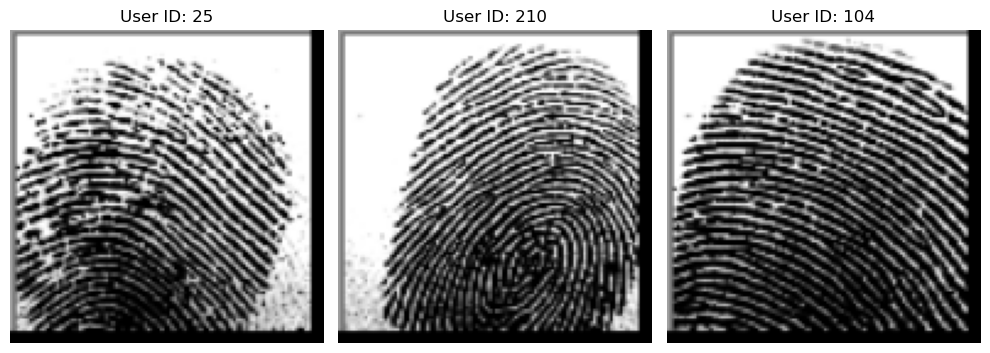

In [3]:
# Select 3 random indices
random_indices = random.sample(range(len(images)), 3)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, ax in enumerate(axes):
    img = images[random_indices[i]]
    user_id = user_ids[random_indices[i]]

    ax.imshow(img)
    ax.set_title(f"User ID: {user_id}")
    ax.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

### List of Possible Actions for Entring One Fingerprint into the Device

#### 1. Rotate with an Arbirary Angle

In [4]:
# Function to rotate the image
def rotate_image(image, angle):
    """Rotate an image (RGB) around its center with white background."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply rotation with white background
    rotated = cv2.warpAffine(
        image,
        M,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)  # White background in RGB
    )

    return rotated

# Reduce five random angles of rotation to be closer to reality
angles = [random.randint(-30, 30) for _ in range(5)]

In [5]:
images.shape

(6000, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


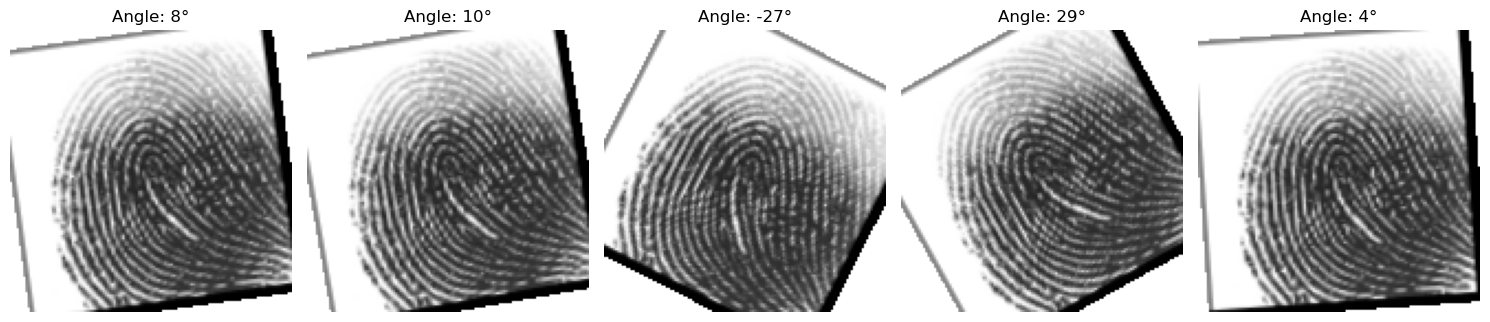

In [6]:
# Select a single random index
random_index = random.choice(range(len(images)))

# Load the fingerprint image
img = images[random_index]
user_id = user_ids[random_index]

# Define the rotation angles
# angles = [-30, -15, 0, 15, 30]  # example angles

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, angle in enumerate(angles):
    rotated_img = rotate_image(img, angle)
    
    # Display the image
    axes[i].imshow(rotated_img)
    axes[i].set_title(f"Angle: {angle}°")
    axes[i].axis('off')
    
    # Convert RGB to BGR for OpenCV saving
    bgr_img = cv2.cvtColor((rotated_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    
    # Save the rotated image
    save_path = f"D:/path_to_save/rotated_{angle}.bmp"
    cv2.imwrite(save_path, bgr_img)

plt.tight_layout()
plt.show()


#### 2. Gaussian Noise

In [7]:
def add_gaussian_noise(image, mean=0, sigma=0.05):
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

#### 3. Crop Center

In [8]:
def crop_center(image, crop_size):
    h, w = image.shape[:2]
    ch, cw = crop_size
    cropped = image[(h - ch) // 2:(h + ch) // 2, (w - cw) // 2:(w + cw) // 2]
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))  # Force output size


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


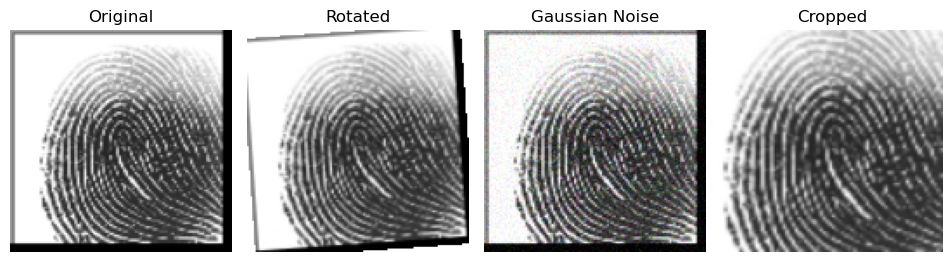

In [9]:
# Display the posssible action on one fingerprint
original_fingerprint = img

augmented_images = [
    original_fingerprint,
    rotate_image(original_fingerprint, angle),
    add_gaussian_noise(original_fingerprint),
    crop_center(original_fingerprint, crop_size=(96, 96))
]

titles = ["Original", "Rotated", "Gaussian Noise", "Cropped"]

plt.figure(figsize=(12, 4))
for i, img in enumerate(augmented_images):
    plt.subplot(1,  5, i + 1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Apply the 3 Actions on Each Fingerprint of the dataset

In [10]:
def load_augmented_dataset(dataset_path, random_crop_size, max_user_id=6000):
    samples = []
    labels = []

    for img_file in os.listdir(dataset_path):
        if not img_file.endswith('.BMP'):
            continue

        user_id = int(img_file.split('__')[0])
        if user_id > max_user_id:
            continue

        img_path = os.path.join(dataset_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Apply transformations
        random_angle = random.randint(-30, 30)
        rotated1 = rotate_image(img, angle=random_angle)

        noisy = add_gaussian_noise(img)

        random_angle = random.randint(-30, 30)
        rotated2 = rotate_image(img, angle=random_angle)

        cropped = crop_center(img, random_crop_size)

        random_angle = random.randint(-30, 30)
        rotated3 = rotate_image(img, angle=random_angle)

        transformed_stack = np.stack([rotated1, noisy, rotated2, cropped, rotated3], axis=0)  # [5, H, W]
        # transformed_stack = np.expand_dims(transformed_stack, axis=-1)   # [5, H, W, 1]

        samples.append(transformed_stack)
        labels.append(user_id)

    return np.array(samples), np.array(labels)

In [11]:
random_size = random.randint(100, 120)
random_crop_size = (random_size, random_size)
IMG_SIZE = 128

samples, labels = load_augmented_dataset(DATASET_PATH, max_user_id=35, random_crop_size=random_crop_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


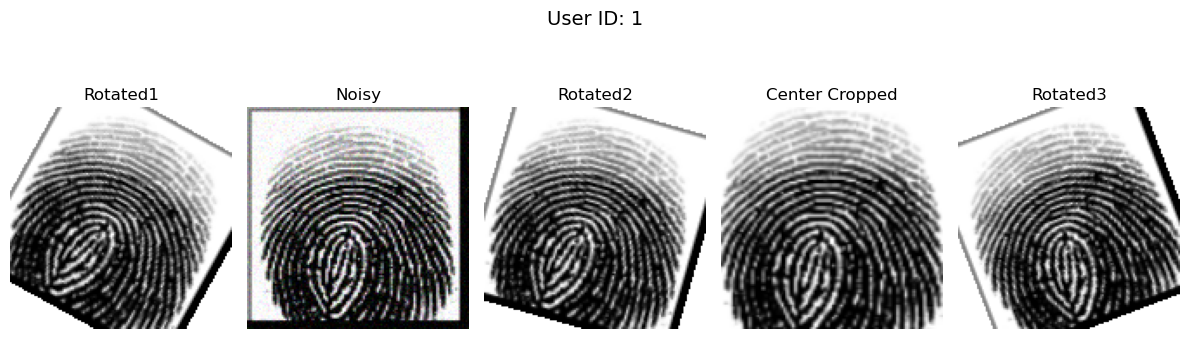

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


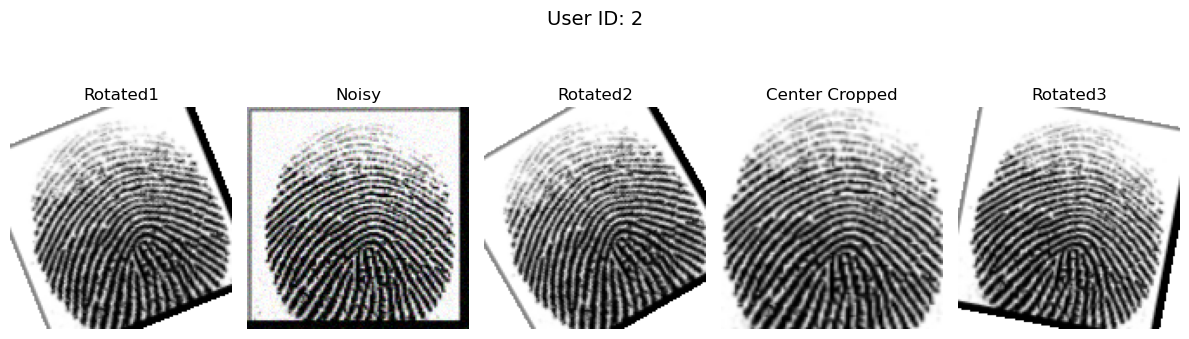

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


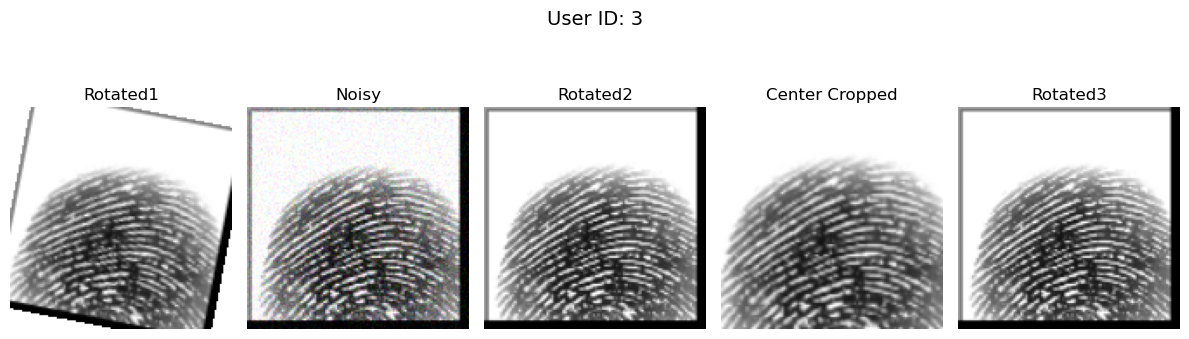

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


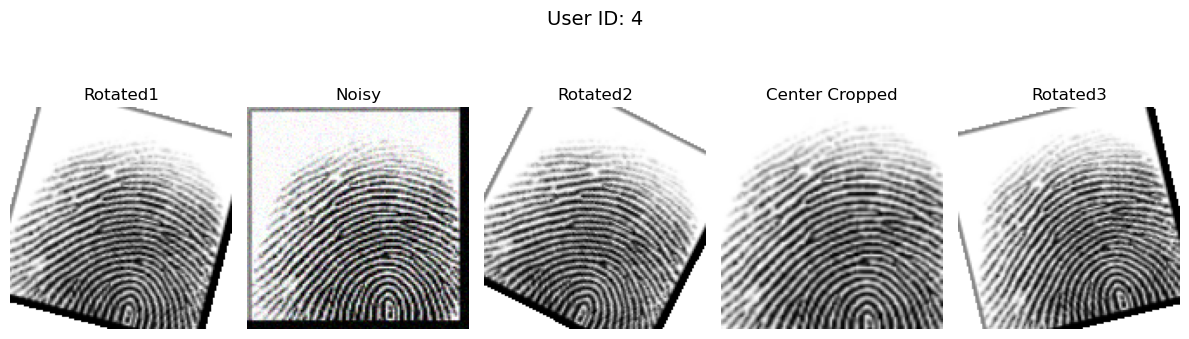

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


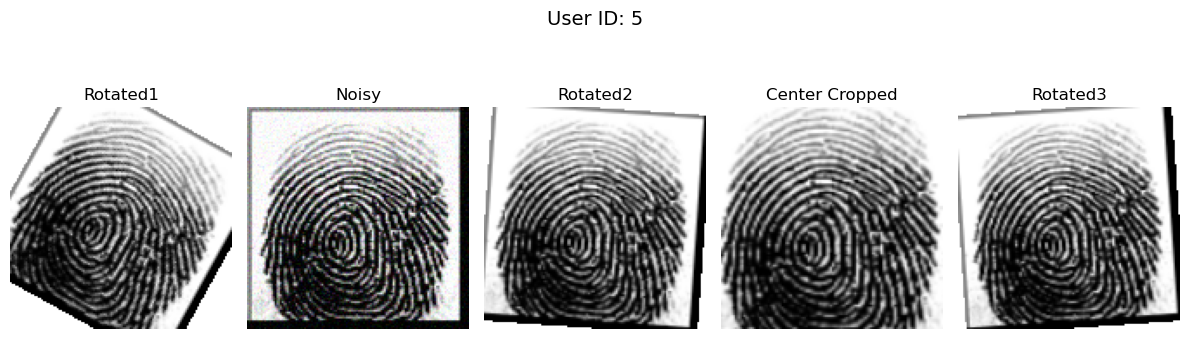

In [12]:
# Get unique user IDs
unique_ids = np.unique(labels)

# Display 1 sample for the first 5 users
for uid in unique_ids[:5]:
    idx = np.where(labels == uid)[0][0]
    sample = samples[idx]  # Shape: [5, H, W, 1]

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    titles = ['Rotated1', 'Noisy', 'Rotated2', 'Center Cropped', 'Rotated3']

    for i in range(5):
        img = sample[i]  # shape [H, W, 3]

        # Just in case, ensure it's resized to 128x128
        if img.shape != (128, 128):
            img = cv2.resize(img, (128, 128))

        axes[i].imshow(img)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    fig.suptitle(f"User ID: {uid}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
np.unique(labels)
# first 35 users

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35])

In [ ]:
samples.shape
# (user_id (35) * 10 (fingers), 5 samples of one fingureprint, img_size, img_size, 3 (channel) )

(350, 5, 128, 128, 3)

In [15]:
labels.shape

(350,)

### FSL Implementation

In [16]:
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes, num_samples, H, W, C = images.shape

    # Flatten to match samples to labels
    all_images = images.reshape(-1, H, W, C)
    all_labels = np.repeat(labels, num_samples)  # Repeat each label 5 times

    for i in range(len(all_images)):
        anchor_img = all_images[i]
        anchor_label = all_labels[i]

        # Positive Pair: same class
        pos_indices = np.where(all_labels == anchor_label)[0]
        pos_indices = pos_indices[pos_indices != i]  # avoid same sample
        if len(pos_indices) > 0:
            pos_idx = np.random.choice(pos_indices)
            pos_img = all_images[pos_idx]
            pairs.append([anchor_img, pos_img])
            pair_labels.append(1)

        # Negative Pair: different class
        neg_indices = np.where(all_labels != anchor_label)[0]
        neg_idx = np.random.choice(neg_indices)
        neg_img = all_images[neg_idx]
        pairs.append([anchor_img, neg_img])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)


In [17]:
pairs, pair_labels = create_pairs(samples, labels)

In [ ]:
pairs.shape
# 35 (user_id) * 10 (fingers) * 5 samples of one fingureprint * 2 (pos & neg pairs)

(3500, 2, 128, 128, 3)

In [19]:
pair_labels.shape

(3500,)

In [20]:
X_a = pairs[:, 0]
X_b = pairs[:, 1]

X_a = np.stack(X_a, axis=0)
X_b = np.stack(X_b, axis=0)

X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(X_a, X_b, pair_labels, test_size=0.2, random_state=42, shuffle=True)

### Feature Extraction

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [22]:
# Load ResNet50 and freeze layers
def build_feature_extractor():
    """Create a ResNet50 feature extractor with frozen layers."""
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # for layer in base_model.layers:
    #     layer.trainable = False  # Freeze all layers

    # Freeze all layers except the last 2 layers
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    # Add a global pooling layer and a dense layer for embeddings
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)  # Trainable layer
    x = Dense(64, activation="relu")(x)  # Trainable layer
    x = Dense(16, activation="relu")(x)  # Trainable layer
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

### Siamese Model

In [23]:
def contrastive_loss(y_true, y_pred, margin=0.6):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Convert y_true to float32
    squared_pred = tf.square(y_pred)  # D^2 for similar pairs
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))  # (margin - D)^2 for dissimilar pairs
    return tf.reduce_mean((1 - y_true) * margin_squared+squared_pred * y_true )

In [24]:
def build_siamese_network():
    feature_extractor = build_feature_extractor()
    
    input_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_b = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)
    
    # Compute Euclidean distance between embeddings
    l2_layer = layers.Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))
    distance = l2_layer([feat_a, feat_b])
    
    siamese_network = models.Model(inputs=[input_a, input_b], outputs=distance)
    siamese_network.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00007,
    beta_1=0.6,
    beta_2=0.666,
    epsilon=1e-9,
    amsgrad=False
    ),
    loss=contrastive_loss, metrics=None)

    # siamese_network.compile(optimizer='adam', loss=contrastive_loss, metrics=None)  # Use contrastive loss
    return siamese_network

In [25]:
BATCH_SIZE = 32
EPOCHS = 50

siamese_network = build_siamese_network()

history = siamese_network.fit(
    [X_train_a, X_train_b], y_train,
    validation_data=([X_val_a, X_val_b], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/50
88/88 [==============================] - 90s 969ms/step - loss: 0.2607 - val_loss: 0.1245
Epoch 2/50
88/88 [==============================] - 81s 919ms/step - loss: 0.1145 - val_loss: 0.1082
Epoch 3/50
88/88 [==============================] - 77s 870ms/step - loss: 0.1100 - val_loss: 0.1172
Epoch 4/50
88/88 [==============================] - 76s 860ms/step - loss: 0.1090 - val_loss: 0.1203
Epoch 5/50
88/88 [==============================] - 70s 802ms/step - loss: 0.1076 - val_loss: 0.1087
Epoch 6/50
88/88 [==============================] - 78s 892ms/step - loss: 0.1046 - val_loss: 0.1150
Epoch 7/50
88/88 [==============================] - 79s 897ms/step - loss: 0.1041 - val_loss: 0.1105
Epoch 8/50
88/88 [==============================] - 85s 963ms/step - loss: 0.1050 - val_loss: 0.1072
Epoch 9/50
88/88 [==============================] - 94s 1s/step - loss: 0.1029 - val_loss: 0.1069
Epoch 10/50
88/88 [==============================] - 77s 871ms/step - loss: 0.1019 - val_loss:

In [26]:
loss= siamese_network.evaluate([X_val_a, X_val_b], y_val)
print(f"Validation Loss: {loss}")

22/22 [==============================] - 15s 659ms/step - loss: 0.1053
Validation Loss: 0.10533304512500763


In [27]:
siamese_network.save("siamese_cnn_model.h5")

### Define Support Set

In [ ]:
######### inference ########


import tensorflow as tf


NUM_WAYS = 2     # classes per episode
NUM_SHOTS = 5 * 10   # examples per class for support set
NUM_QUERIES = 2 * 10  # query example per class (you'll use your 4 new images)


# Load the trained model
siamese_net = siamese_network


DATASET_PATH_SUPPORT = "My Local Path/SOCOFing/Support/"

# Load images and user_ids
support_images, support_user_ids = load_images(DATASET_PATH_SUPPORT)

# Print shape of the dataset
print(f"Loaded {support_images.shape[0]} images with shape {support_images.shape[1:]} for support set.")
print(f"User IDs: {np.unique(support_user_ids)}")

Loaded 100 images with shape (128, 128, 3) for support set.
User IDs: [591 592 593 594 595 596 597 598 599 600]


In [ ]:
support_images.shape
# (10)ids * 10 fingureprints

(100, 128, 128, 3)

In [30]:
support_user_ids.shape

(100,)

### Retrain the Network with Support Set

In [31]:
random_size = random.randint(100, 120)
random_crop_size = (random_size, random_size)
IMG_SIZE = 128

support_samples, support_labels = load_augmented_dataset(DATASET_PATH_SUPPORT, random_crop_size=random_crop_size)

In [32]:
support_samples.shape

(100, 5, 128, 128, 3)

In [33]:
support_labels.shape

(100,)

In [34]:
support_pairs, support_pair_labels = create_pairs(support_samples, support_labels)

In [35]:
siamese_network.fit(
    [support_pairs[:, 0], support_pairs[:, 1]],
    support_pair_labels,
    epochs=30,
    batch_size=32
)

Epoch 1/30
32/32 [==============================] - 21s 656ms/step - loss: 0.0946
Epoch 2/30
32/32 [==============================] - 20s 638ms/step - loss: 0.0893
Epoch 3/30
32/32 [==============================] - 20s 617ms/step - loss: 0.0891
Epoch 4/30
32/32 [==============================] - 26s 832ms/step - loss: 0.0821
Epoch 5/30
32/32 [==============================] - 20s 621ms/step - loss: 0.0851
Epoch 6/30
32/32 [==============================] - 19s 600ms/step - loss: 0.0802
Epoch 7/30
32/32 [==============================] - 19s 598ms/step - loss: 0.0781
Epoch 8/30
32/32 [==============================] - 19s 601ms/step - loss: 0.0800
Epoch 9/30
32/32 [==============================] - 19s 598ms/step - loss: 0.0770
Epoch 10/30
32/32 [==============================] - 19s 601ms/step - loss: 0.0752
Epoch 11/30
32/32 [==============================] - 19s 598ms/step - loss: 0.0731
Epoch 12/30
32/32 [==============================] - 19s 603ms/step - loss: 0.0759
Epoch 13/30
3

### Define Query Set

In [ ]:
DATASET_PATH_QUERY = "My Local Path/SOCOFing/Support/"

# Load images and user_ids
query_images, query_user_ids = load_images(DATASET_PATH_QUERY)

# Print shape of the dataset
print(f"Loaded {query_images.shape[0]} images with shape {query_images.shape[1:]} for query set.")
print(f"User IDs: {np.unique(query_user_ids)}")

Loaded 100 images with shape (128, 128, 3) for query set.
User IDs: [591 592 593 594 595 596 597 598 599 600]


In [37]:
query_images.shape

(100, 128, 128, 3)

In [38]:
query_user_ids.shape

(100,)

In [39]:
# Apply 5 rotations to each image
augmented_images = []
augmented_labels = []

for img, uid in zip(query_images, query_user_ids):
    angles = [random.randint(-30, 30) for _ in range(5)]
    for angle in angles:
        rotated = rotate_image(img, angle)
        augmented_images.append(rotated)
        augmented_labels.append(uid)

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Augmented query set shape: {augmented_images.shape}")
print(f"User IDs in augmented query set: {np.unique(augmented_labels)}")

Augmented query set shape: (500, 128, 128, 3)
User IDs in augmented query set: [591 592 593 594 595 596 597 598 599 600]


In [40]:
def classify_images(support_images, support_labels, query_images, model, num_ways, num_shots):
    predictions = []

    # Get the unique user IDs in the same order they appear (class mapping)
    unique_user_ids = np.unique(support_labels)
    id_map = {i: uid for i, uid in enumerate(unique_user_ids)}  # index → real user ID

    for query_img in query_images:
        query_img = tf.expand_dims(query_img, axis=0)  # Shape: [1, H, W, C]

        # Repeat the query image to match support set shape
        tiled_query = np.tile(query_img, (support_images.shape[0], 1, 1, 1))  # Shape: [support_size, H, W, C]

        # Predict similarity scores
        scores = model.predict([tiled_query, support_images])

        # Aggregate scores per class (average similarity across shots)
        aggregated_scores = np.zeros(num_ways)
        for i in range(num_ways):
            aggregated_scores[i] = np.mean(scores[i * num_shots:(i + 1) * num_shots])

        predicted_class_index = np.argmax(aggregated_scores)
        predicted_user_id = id_map[predicted_class_index]
        predictions.append(predicted_user_id)

    return predictions


In [41]:
predictions = classify_images(
    support_images=support_images,
    support_labels=support_labels,
    query_images=query_images,
    model=siamese_net,
    num_ways=NUM_WAYS,
    num_shots=NUM_SHOTS
)

In [42]:
# Display results
for i, pred_uid in enumerate(predictions):
    real_uid = query_user_ids[i]
    print(f"Query {i + 1}: Predicted User ID -> {pred_uid}, Real User ID -> {real_uid}")


Query 1: Predicted User ID -> 592, Real User ID -> 591
Query 2: Predicted User ID -> 591, Real User ID -> 591
Query 3: Predicted User ID -> 592, Real User ID -> 591
Query 4: Predicted User ID -> 592, Real User ID -> 591
Query 5: Predicted User ID -> 591, Real User ID -> 591
Query 6: Predicted User ID -> 592, Real User ID -> 591
Query 7: Predicted User ID -> 591, Real User ID -> 591
Query 8: Predicted User ID -> 591, Real User ID -> 591
Query 9: Predicted User ID -> 592, Real User ID -> 591
Query 10: Predicted User ID -> 591, Real User ID -> 591
Query 11: Predicted User ID -> 592, Real User ID -> 592
Query 12: Predicted User ID -> 592, Real User ID -> 592
Query 13: Predicted User ID -> 592, Real User ID -> 592
Query 14: Predicted User ID -> 592, Real User ID -> 592
Query 15: Predicted User ID -> 592, Real User ID -> 592
Query 16: Predicted User ID -> 592, Real User ID -> 592
Query 17: Predicted User ID -> 592, Real User ID -> 592
Query 18: Predicted User ID -> 592, Real User ID -> 592
Q

In [43]:
predictions = np.array(predictions)
query_labels = np.array(query_user_ids)

accuracy = np.mean(predictions == query_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 15.00%


### How does the algorithm work?
In this algorithm the new user is identified with 5 fingerprints. This is done through augmention of three rotations with random angle, noisy and crop center functions for each user.
Then, the Siamese network is trained with this dataset and retrained with the support set with the IDs from 591 to 600.
The query set consists of a random rotation of 1 fingerprint of IDs 591 to 600, and the network identifies this user.

In [44]:
# Pariya Khalili